# Sales Prediction Project
Author: [Sébastien Lozano Forero](https://www.linkedin.com/in/sebastienlozanoforero/)

September, 2021. 

## Abstract

<img style="float: right;" src="img/CRISP-DM_Process_Diagram.png" width="350">

This projects aimed to propose a solution for the Rossmann Challenge, first published in [Kaggle](https://www.kaggle.com/c/rossmann-store-sales). The main goal was to provide forecasted values for revenue across Rossmann stores.
To this end and based on the [CRoss-Industry Standard Process for data mining (CRISP)](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining) methodology, the following steps were taken: 




* [Step 01 - Data Description](#step01)
* [Step 02 - Feature Engineering](#step02)
* [Step 03 - Data Filtering](#step03)
* [Step 04 - Exploratory Analysis](#step04)
* [Step 05 - Data Preparation](#step05)
* [Step 06 - Feature Selection](#step06)
* [Step 07 - Machine Learning Modeling](#step07)
* [Step 08 - Hyperparameter Fine Tuning](#step08)
* [Step 09 - Translation and interpretation](#step09)
* [Step 10 - Model Deployment](#step10)


## Package imports

In [35]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import requests
import warnings
import inflection
import datetime
import seaborn as sns
import xgboost as xgb
import scipy.stats as stats    
from distfit import distfit

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

## Helper Functions

In [110]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
#     display( HTML( '<style>.container { width:100% !important; }</style>') )
#     pd.options.display.max_columns = None
#     pd.options.display.max_rows = None
#     pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## Loading data

Once data was downloaded, we start the process by loading the *train* and *store* datasets. *train* would contain information regarding the sales while *store* would contain information on the the specifics of the store. 

In [5]:
df_sales_raw = pd.read_csv( 'C:/Users/Windows/Google Drive/DS em produccao/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'C:/Users/Windows/Google Drive/DS em produccao/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

In [6]:
print('Sales dataframe shape{}'.format(df_sales_raw.shape))
print('Store dataframe shape{}'.format(df_store_raw.shape))

Sales dataframe shape(1017209, 9)
Store dataframe shape(1115, 10)


This is, the solution we aim to build would involve 1115 stores and over 1 Million sales. 

#  Step 01 - Data Description <a class="anchor" id="step01"></a>

The following variables are included in the merged files: 

- **ID** - an Id that represents a (Store, Date) duple within the test set
- **Store** - a unique Id for each store
- **Sales** - the turnover for any given day (this is the variable we want to forecast)
- **Customers** - the number of customers on a given day
- **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
- **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo** - indicates whether a store is running a promo on that day
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
* **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [7]:
df1 = df_raw.copy()

## Rename Columns

Removing capital letters from the name of our variables.

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## Data Dimensions

In [9]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## Data Types

Checking the types of our columns.

In [10]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Checking NAs

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

The missing data points are entirely related to competition and promotions information. 

## Fillout NA

Some assumptions were made in order to fill NA values. 
- If no competition distance was available (this is, no other store from a different company was reported), a value of 20000 was imputed.
- If no information on the time when competition was open, date of the sale is going to be used to impute such NaNs
- Promo intervals are important to predict sales and thus, they are associated with sales as dummy variable

## Data Preview

In [13]:
df1.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [14]:
#competition_distance        
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week           
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval              
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )


In [15]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## Change Data Types

In [16]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## Descriptive Statistics

For EDA, we will split the now clean dataset in two pieces: numerical variables and categorical variables

In [17]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### Numerical Atributes

Some numerical measures for the numerical variables

In [18]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.155231,0.0,0.362124,1.904152,1.625796


<AxesSubplot:xlabel='competition_distance'>

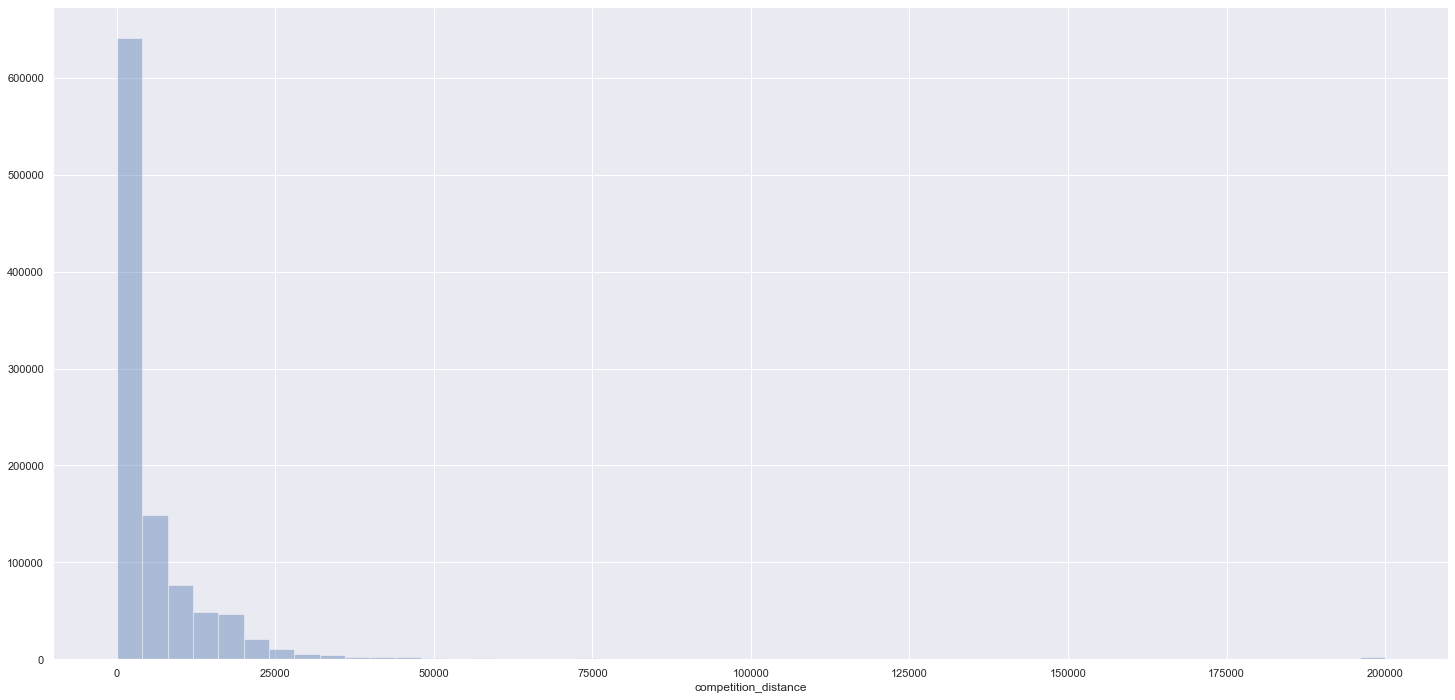

In [19]:
sns.distplot( df1['competition_distance'], kde=False )

### Categorical Atributes

In [20]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

How is the relation of some of these categorical variables with the sales value? 

<AxesSubplot:xlabel='assortment', ylabel='sales'>

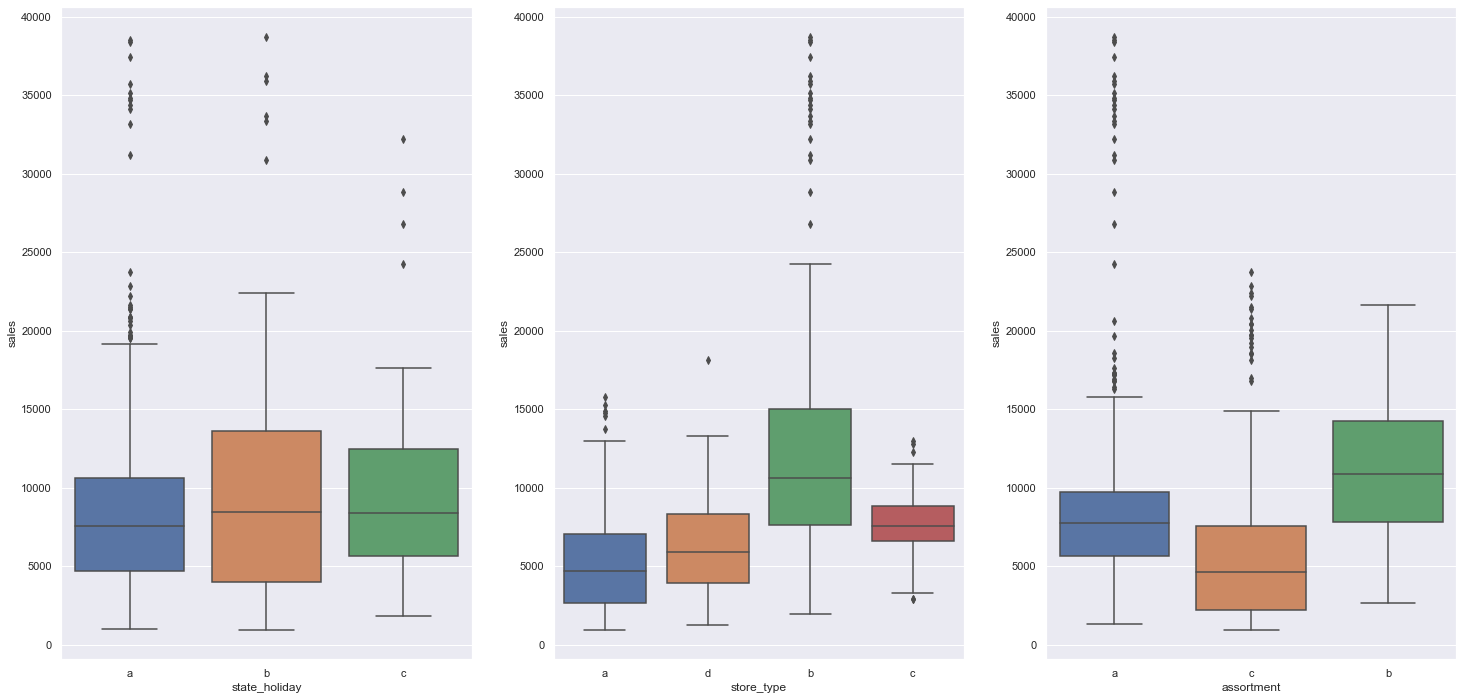

In [21]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

Sales not seems to be very influenced by the type of holiday. Type b stores and type b assortment seem to display higher selling volume. 

# Step 02 - Feature Engineering <a class="anchor" id="step02"></a>

Some modifications are going to be handle in the data in order to better use the available information when using Machine Learning algorithms. But first, and as a way to gain some understanding on the data, some hypothesis are proposed and then assessed.

In [25]:
df2 = df1.copy()

## Hypothesis map

- Phenomenon: What am I modeling (Daily Store Sales)
- Agents: What are the agents that act on the phenomenon (five main branches)
- Agent Attributes: What is the description of the agents (branches on each agent)

The goal is to derive a list of hypotheses to be assessed within the data. Every hypothesis validated or discarded is an  insight.

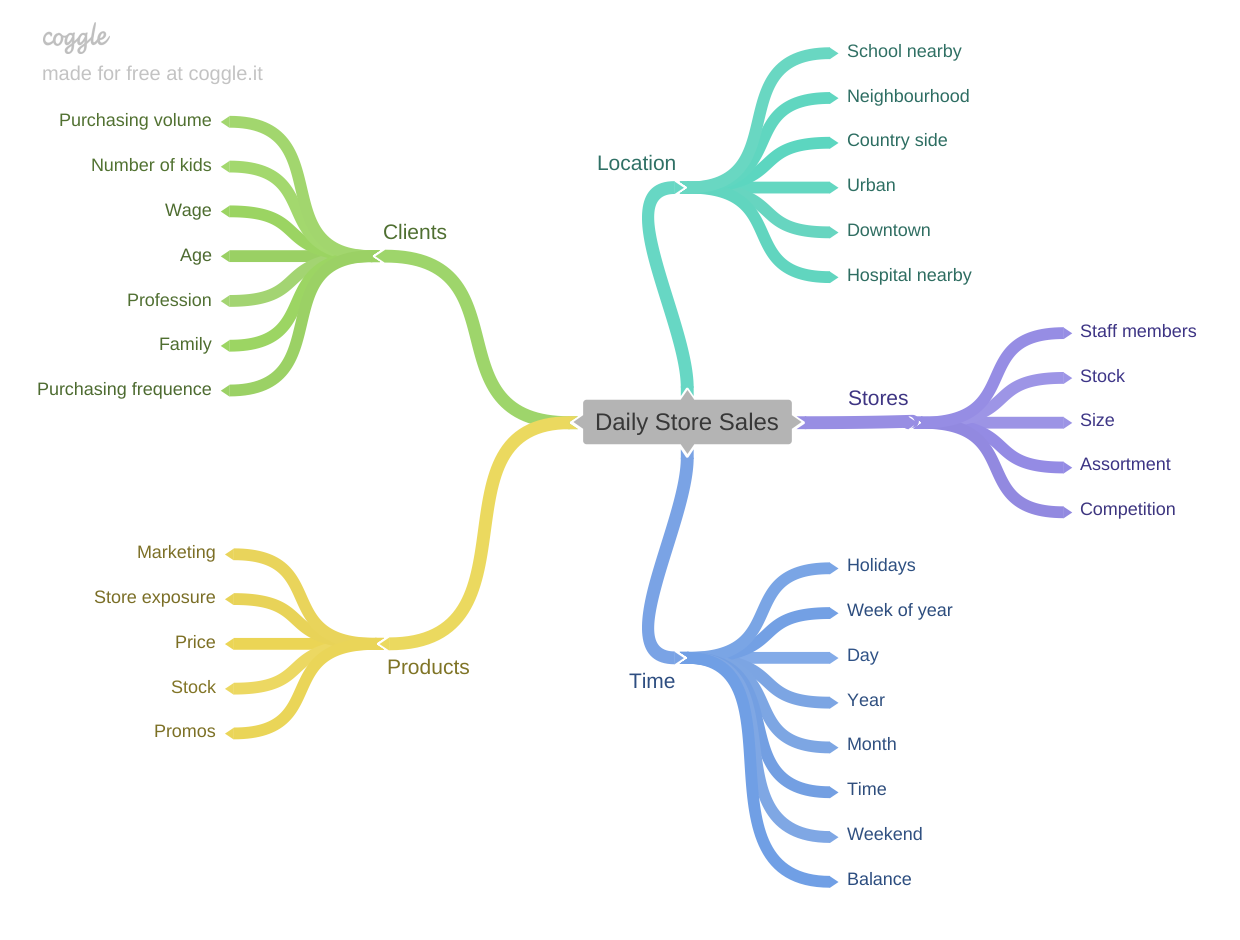

In [23]:
Image( 'img/DAILY_SOTORE_SALES.png' )

## Some Hypothesis 

### Store hypothesis

**1.** Higher number of employees should lead to higher selling volume

**2.** Higher stocked stores should lead to higher selling volume

**3.** Bigger stores should lead to higher selling volume

**4.** Better assortment in stores should lead to higher selling volume

**5.** Stores having competitors nearby should have less selling volume

**6.** Stores having lasting competitors nearby should have less selling volume

### Product hypothesis

**1.** Stores investing more in marketing should lead to higher selling volume

**2.** The more products being exposed in showcase should lead to higher selling volume

**3.** Stores displaying less priced product should lead to higher selling volume

**4.** Stores displaying less priced product longer should lead to higher selling volume

**5.** The more aggressive a promo is, the higher the selling volume

**6.** Stores displaying longer promos should have a higher selling volume 

**7.** More days with an active promo should lead to higher selling volume 

**8.** Stores displaying more consecutive promos should have higher selling volume

###  Time hypothesis

**1.** Stores having more holidays should lead to lesser selling volume

**2.** Stores should have higher selling volume through years

**3.** Stores should have higher selling volume on second semester each year

**4.** Stores should have higher selling volume after day 10 of month

**5.** Stores should have lesser selling volume on weekends

**6.** Stores should have lesser selling volume on school holidays

## Final list of hypothesis. 

**1.** Better assortment in stores should lead to higher selling volume

**2.** Stores having competitors nearby should have less selling volume

**3.** Stores having lasting competitors nearby should have less selling volume

**4.** Stores displaying longer promos should have a higher selling volume 

**5.** More days with an active promo should lead to higher selling volume 

**6.** Stores displaying more consecutive promos should have higher selling volume

**7.** Stores having more holidays should lead to lesser selling volume

**8.** Stores should have higher selling through years

**9.** Stores should have higher selling volume on second semester each year

**10.** Stores should have higher selling volume after day 10 of month

**11.** Stores should have lesser selling volume on weekends

**12.** Stores should have lesser selling volume on school holidays

## Feature Engineering

Basic modifications are made to some of the considered variables, specially in variables involving time and re codifying values in categorical variables. 

In [26]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

# Step 03 - Data Filtering <a class="anchor" id="step03"></a>

The motivation for data filtering is business restrictions and ability to deploy the model into production. This is, we need information that i) is useful to the model (make sense when trying to explain the selling values), and ii) is available when the deployed model is going to be used to forecast values, so the operation is mathematically feasible. 

In [27]:
df3 = df2.copy()

## Row Filtering


We want to focus on non-null sales made in open stores. 

In [28]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## Column Selection

In [29]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# Step 04 - Exploratory Analysis <a class="anchor" id="step04"></a>

We carry out an Exploratory Data Analysis (EDA) with three goals in mind. 
- Gain business experience and knowledge
- Validate hypothesis (this is, generating insights)
- Gain intuition on what variables could be meaningful to the model

Three approaches are available to these ends
- Univariate analysis. Basic information on each variable of the set. 
- Bivariate analysis. Relations between the endogenous variable with the exogenous variables. 
- Multivariate analysis. How the exogenous variables are related between them (correlation). 

In [66]:
df4 = df3.copy()

## Univariate Analysis

### Response Variable

<AxesSubplot:xlabel='sales'>

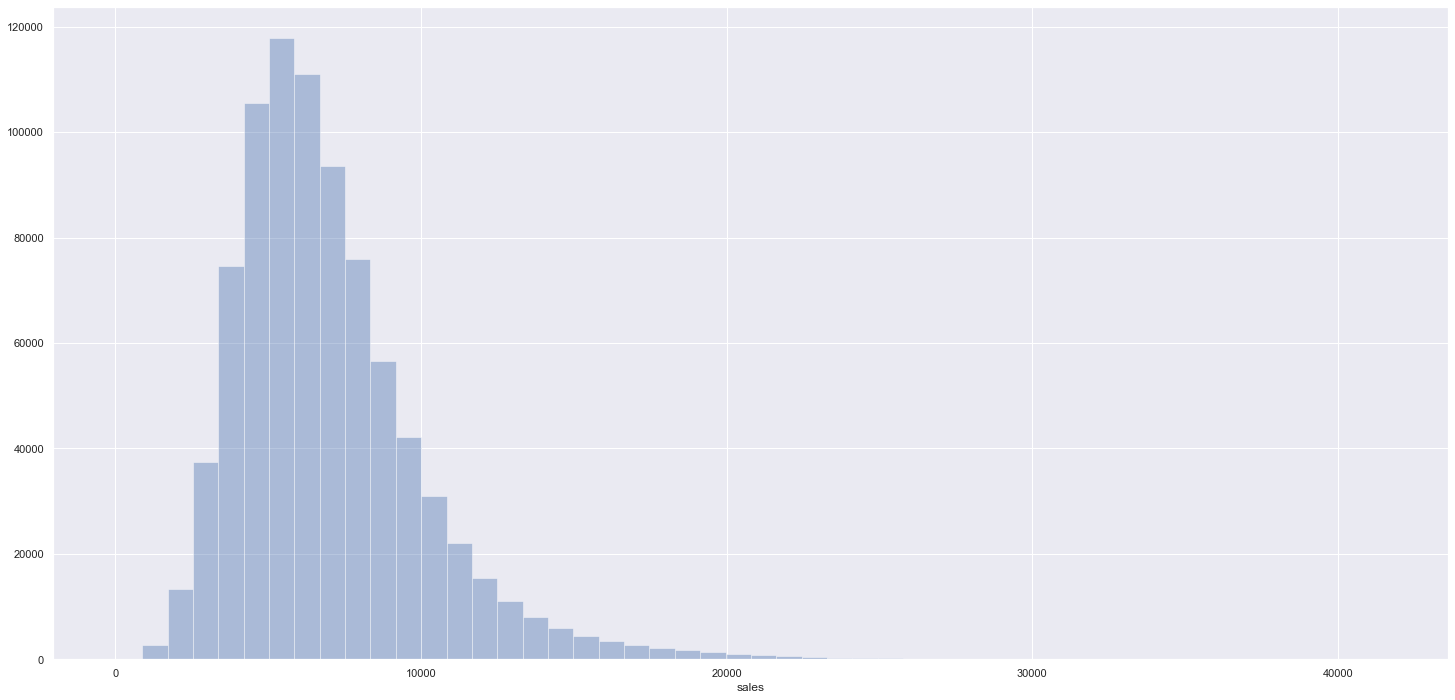

In [31]:
sns.distplot( df4['sales'], kde=False  )

What seems to be the most reasonable distribution for the response variable? 

In [60]:
dist = distfit()
dist.fit_transform(df4['sales'])

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.02 sec] [RSS: 0.0000000] [loc=6955.959 scale=3103.814]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.0000001] [loc=46.000 scale=6909.959]
[distfit] >[pareto    ] [24.6 sec] [RSS: 0.0000002] [loc=-0.033 scale=46.033]
[distfit] >[dweibull  ] [20.3 sec] [RSS: 0.0000000] [loc=6492.513 scale=2327.669]
[distfit] >[t         ] [32.4 sec] [RSS: 0.0000000] [loc=6956.047 scale=3103.798]
[distfit] >[genextreme] [101. sec] [RSS: 0.0000001] [loc=1013.093 scale=5467.437]
[distfit] >[gamma     ] [33.2 sec] [RSS: 0.0000000] [loc=41.666 scale=1179.490]
[distfit] >[lognorm   ] [60.9 sec] [RSS: 0.0000000] [loc=-630.452 scale=7043.135]
[distfit] >[beta      ] [44.8 sec] [RSS: 0.0000000] [loc=45.367 scale=6736590958.733]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.0000001] [loc=46.000 scale=41505.000]
[distfit] >[loggamma  ] [20.1 sec] [RSS: 0.0000000] [loc=-1242773.443 scale=159829.671]
[distfit] >Compute confidence interval [parametric]


{'model': {'distr': <scipy.stats._continuous_distns.lognorm_gen at 0x27297d4c070>,
  'stats': 'RSS',
  'params': (0.3831288504455713, -630.4515121208032, 7043.134744520074),
  'name': 'lognorm',
  'model': <scipy.stats._distn_infrastructure.rv_frozen at 0x272c1e7a9a0>,
  'score': 3.157526329061447e-10,
  'loc': -630.4515121208032,
  'scale': 7043.134744520074,
  'arg': (0.3831288504455713,),
  'CII_min_alpha': 3119.94836437293,
  'CII_max_alpha': 12596.337273890593},
 'summary':          distr score  LLE             loc              scale  \
 0      lognorm   0.0  NaN     -630.451512        7043.134745   
 1        gamma   0.0  NaN       41.665718        1179.490018   
 2         beta   0.0  NaN       45.367433  6736590958.732882   
 3     dweibull   0.0  NaN      6492.51332         2327.66866   
 4         norm   0.0  NaN     6955.959134        3103.813677   
 5            t   0.0  NaN     6956.046998        3103.798122   
 6     loggamma   0.0  NaN -1242773.442968      159829.670991 

[distfit] >plot..


(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'\nlognorm\ns=0.38, loc=-630.45, scale=7043.13'}, xlabel='Values', ylabel='Frequency'>)

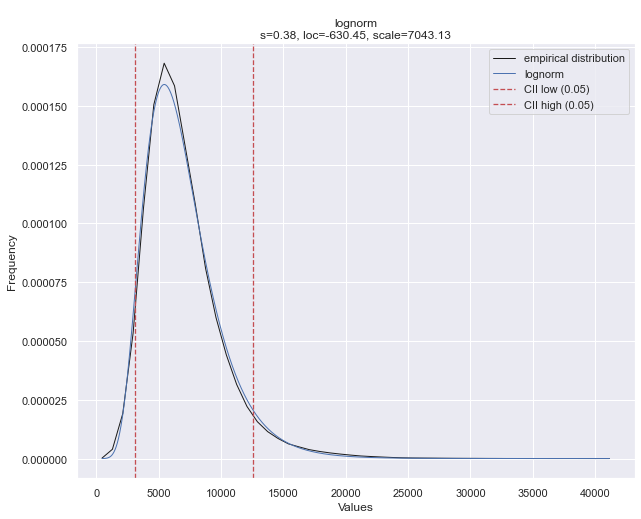

In [62]:
dist.plot()

Sales is better fitted by a Log-normal distribution, so we could assume a log-normal distribution for sales. 

### Numerical Variable

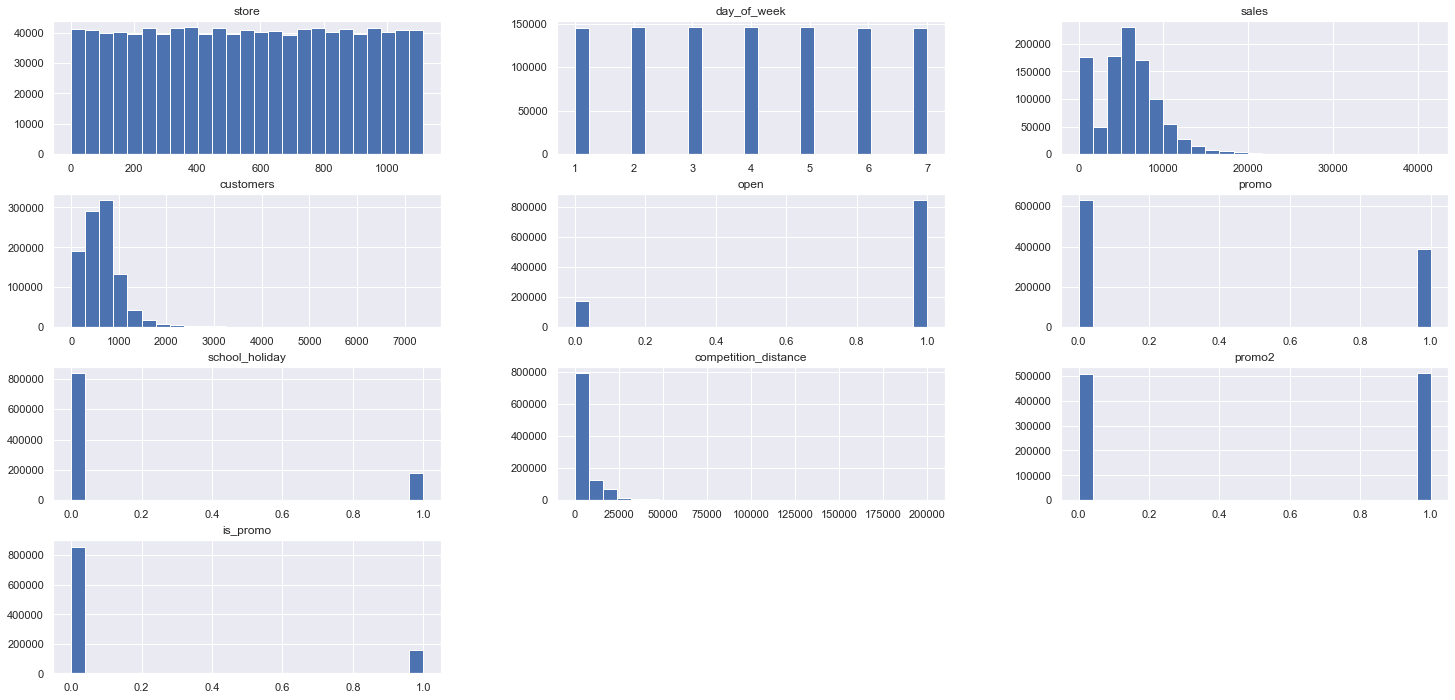

In [68]:
num_attributes.hist( bins=25 );

Some notes:

- Almost the same number of data points for each store
- No major influence is noted on sales and day of the week
- Same distribution of sales seems to occur for the number of customers
- promo2 is present in half of the available data

### Categorical Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

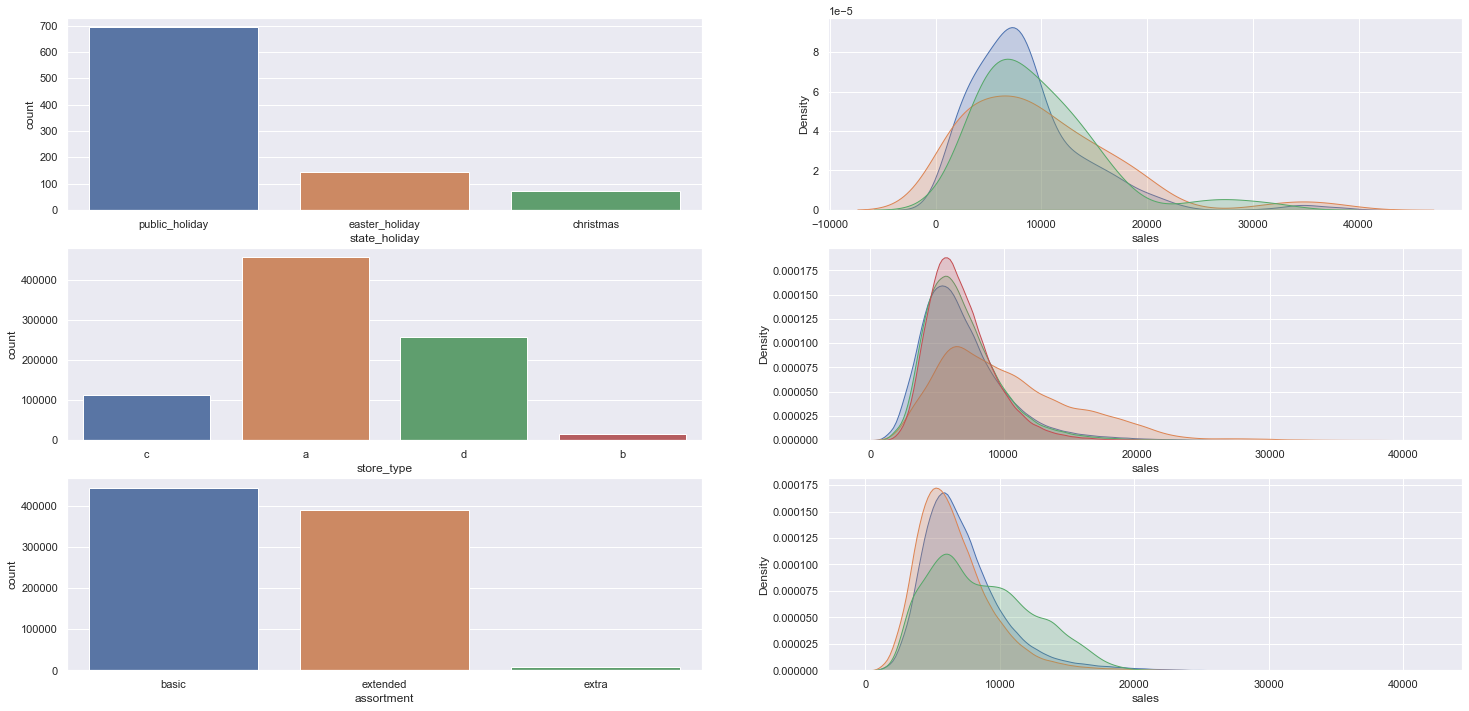

In [64]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

Some notes:

- Higher selling volume is registered from public holidays
- Type a of store types and basic assortments. 
- Extra assorted and type b of stores seem to have less operations but with higher selling value. 


## Bivariate Analysis

### **H1.** Higher assortment should lead to higher selling volume
**FALSE** Most assorted stores sell less. In fact, basic and extended assorted stores would display significantly higher selling volume

<AxesSubplot:xlabel='year_week'>

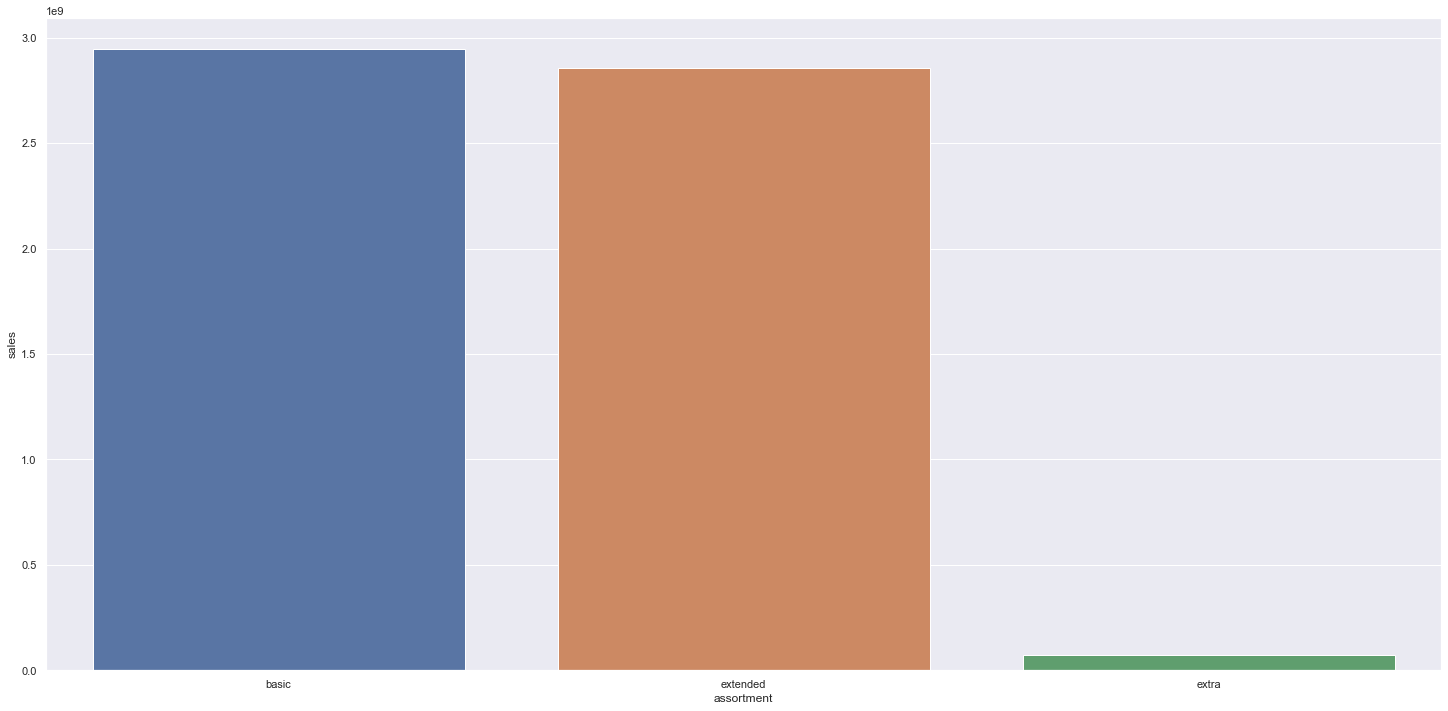

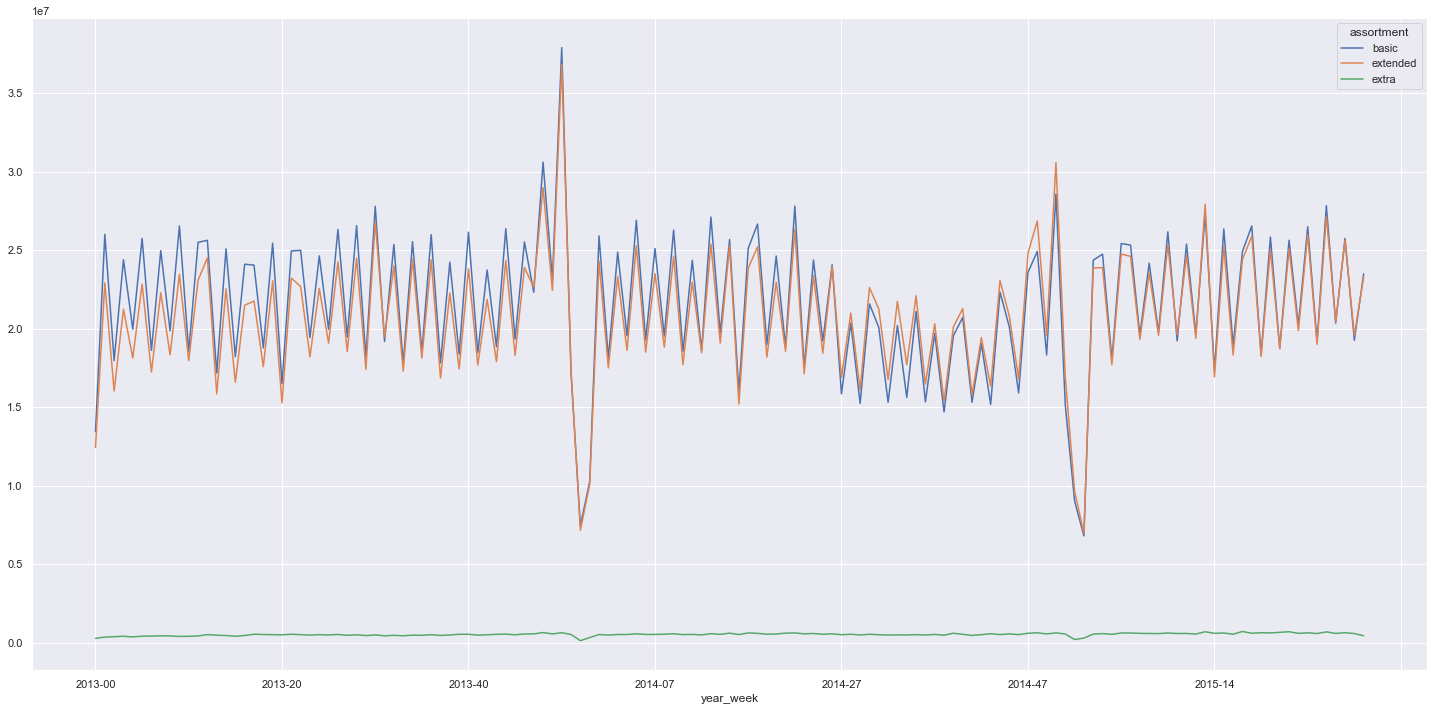

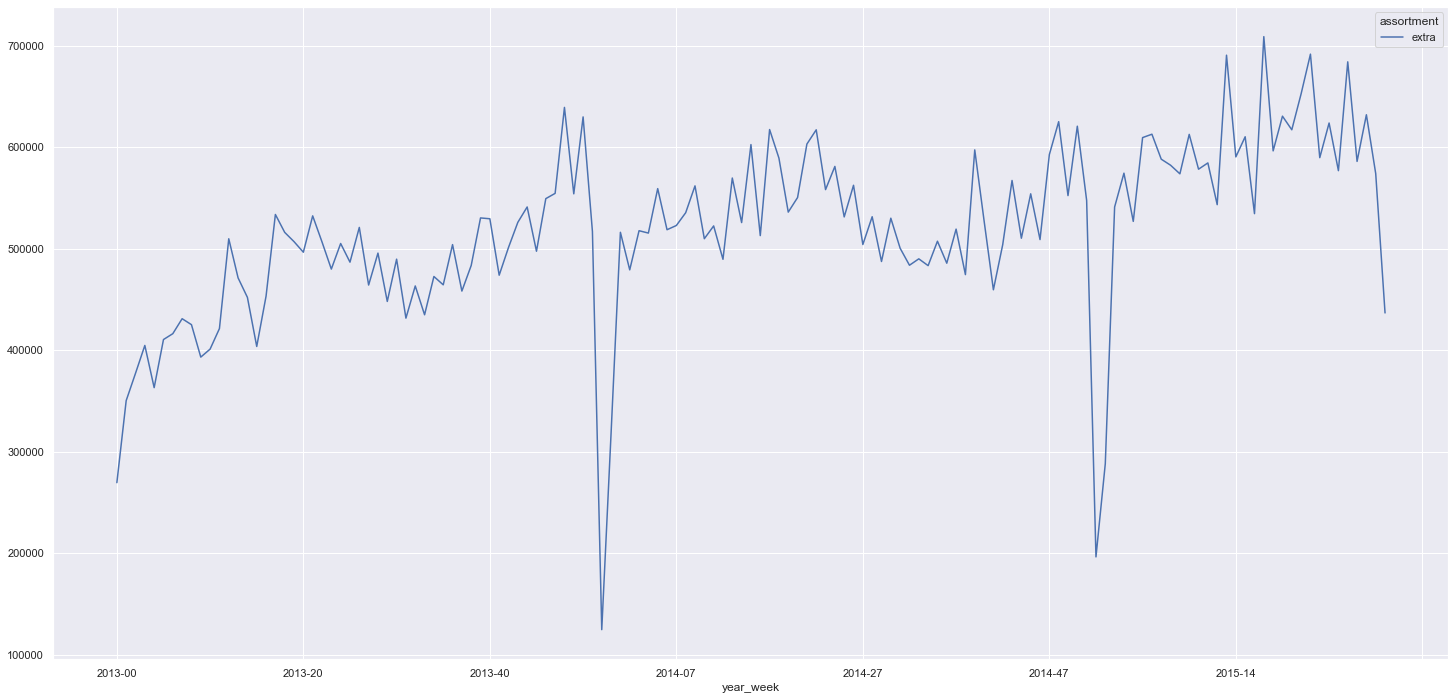

In [65]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

Neverthless, it should be noted that the conclusion would apply in volume. Considering the amount of each type of store 

In [72]:
df4[['store','assortment']].drop_duplicates().groupby('assortment').count().reset_index()

,assortment,store
0,basic,593
1,extended,513
2,extra,9


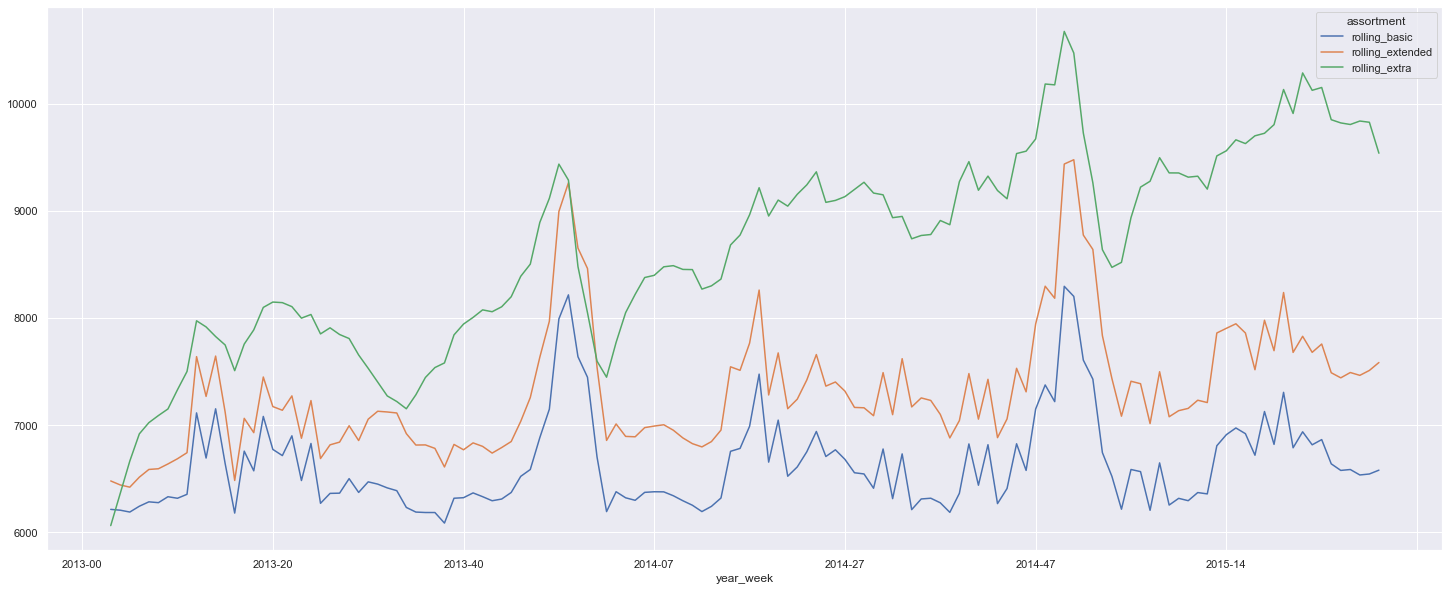

In [69]:
aux1 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).mean().reset_index()
aux2 = aux1.pivot(index='year_week', columns = 'assortment', values='sales').reset_index()

aux2['rolling_basic'] = aux2['basic'].rolling(4).mean()
aux2['rolling_extended'] = aux2['extended'].rolling(4).mean()
aux2['rolling_extra'] = aux2['extra'].rolling(4).mean()
aux2 = aux2.set_index('year_week')[['rolling_basic','rolling_extended','rolling_extra' ]]
aux2.plot(figsize=(25,10));

So, stores with more assortment would display less absolute selling volume (there is a higher number of basic stores, so revenue would come in bigger proportion from this assortment type), but would display a higher price value per sale. 

### **H2.** Stores having competence stores nearby should have lesser selling volume
**FALSE**, stores having competence stores nearby have higher selling volume

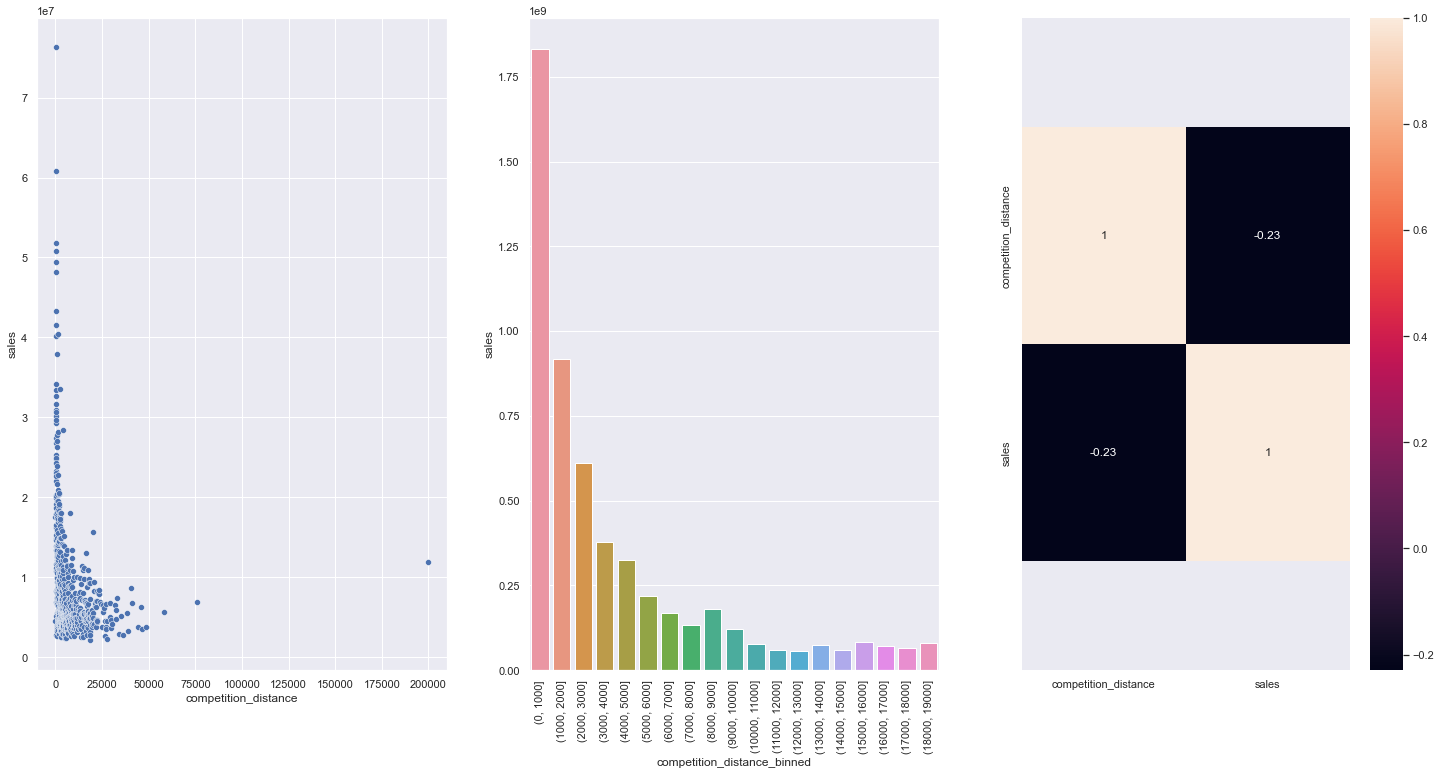

In [73]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

### **H3.**  Stores with longer-standing competition display higher selling volume
**FALSE** stores with longer-standing competition would not have higher selling volume

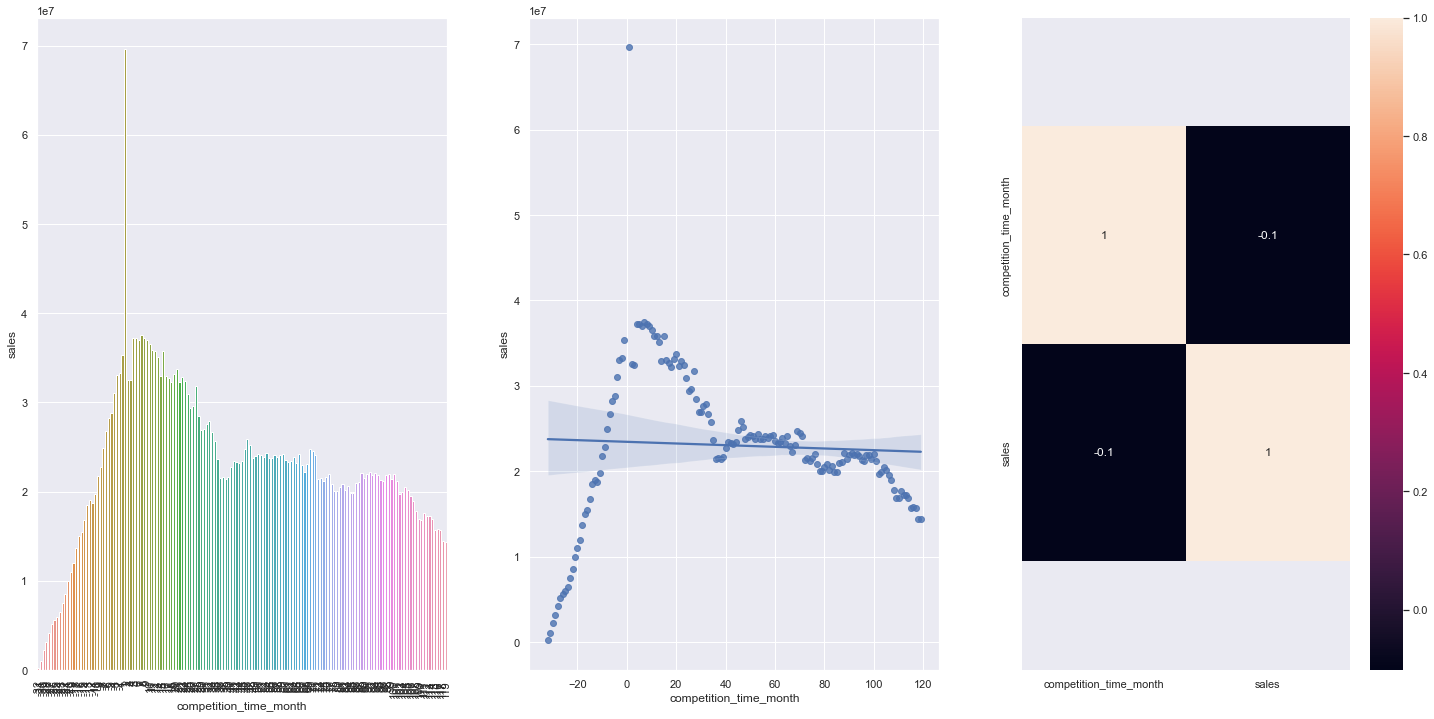

In [74]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

### **H4.**  Longer active promos should lead to higher sellings
**FALSE** stores with lasting promos are selling less, after a certain promo period

There is a point where a product with higher selling volume start to decay on sales. It makes sense to think that such product is more assorted than others, so when sales start to going down, they promo time starts in order to boost sales. Once the promo is put in place, it will stabilize the selling of the product and then, selling are expected to drop. 

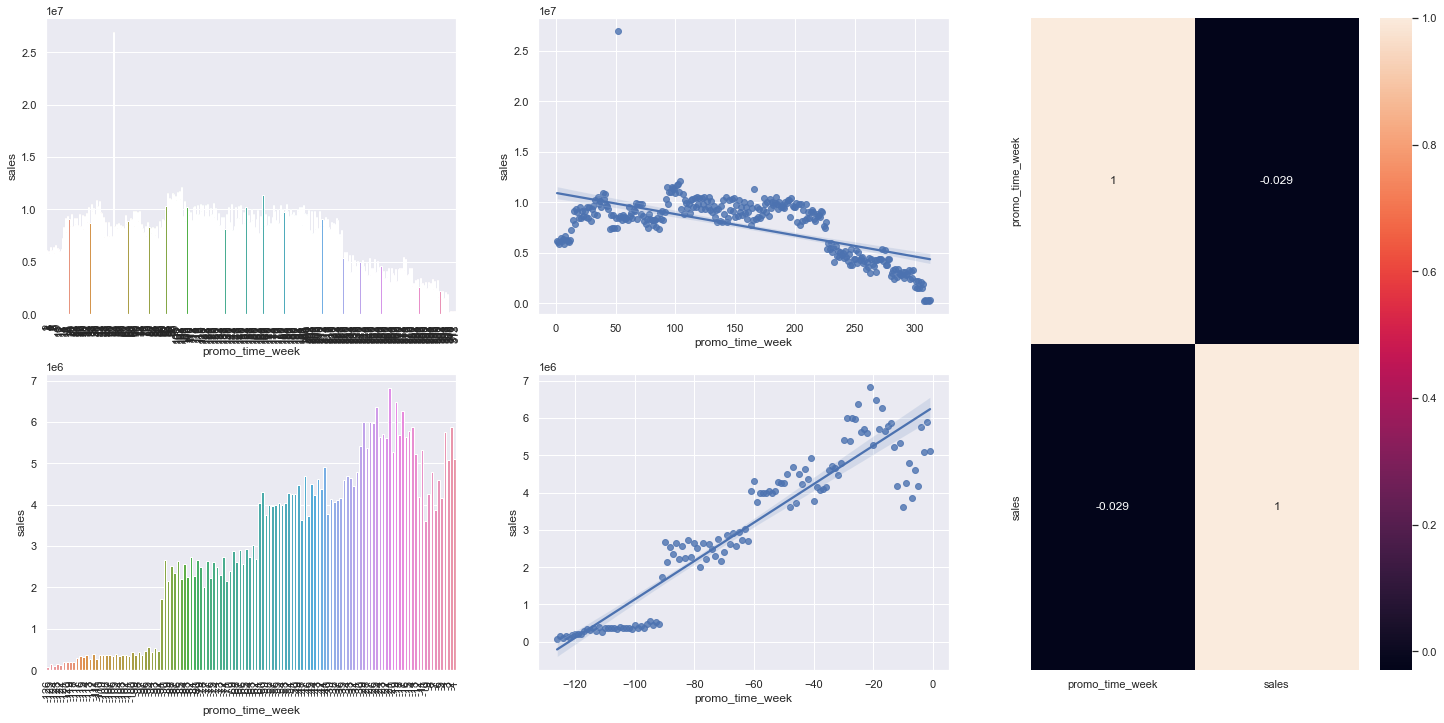

In [75]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### <s> **H5.** Stores with more days with promos  should display higher sellings.</s>

### **H6.** Stores with more consecutive promos should display higher sellings
**FALSE** Stores displaying more consecutive promos are actually selling less

In [76]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


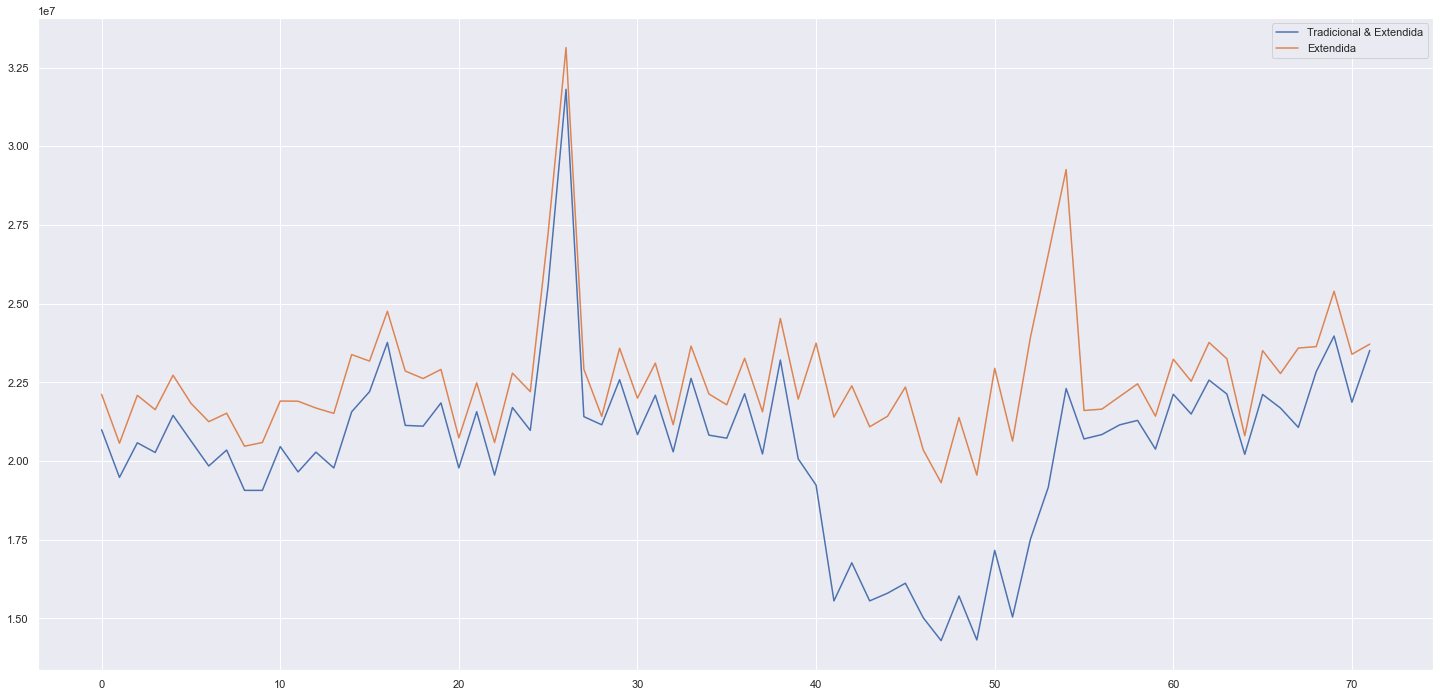

In [77]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### **H7**. Stores being opened on crhistmas should display higher selling volume
**FALSE**. No higher selling volume is displayed on crhistmas

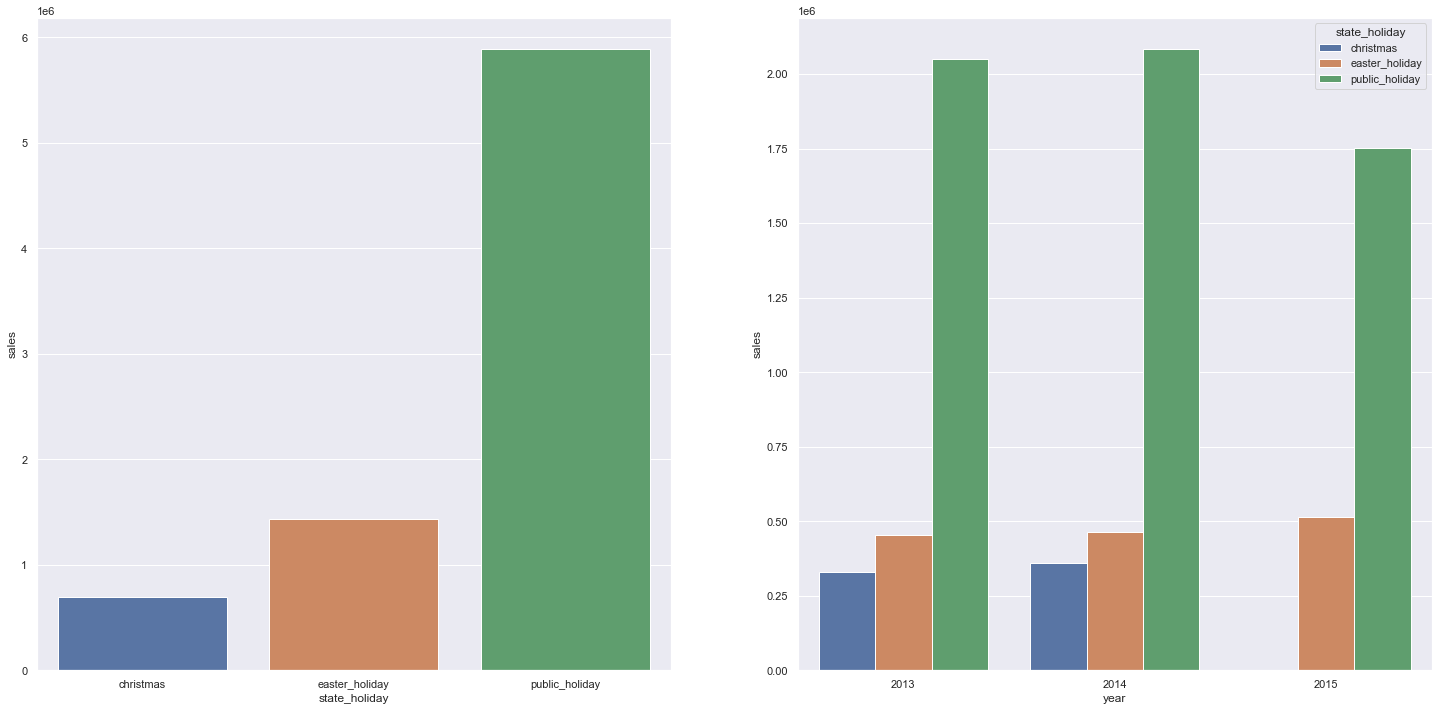

In [78]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

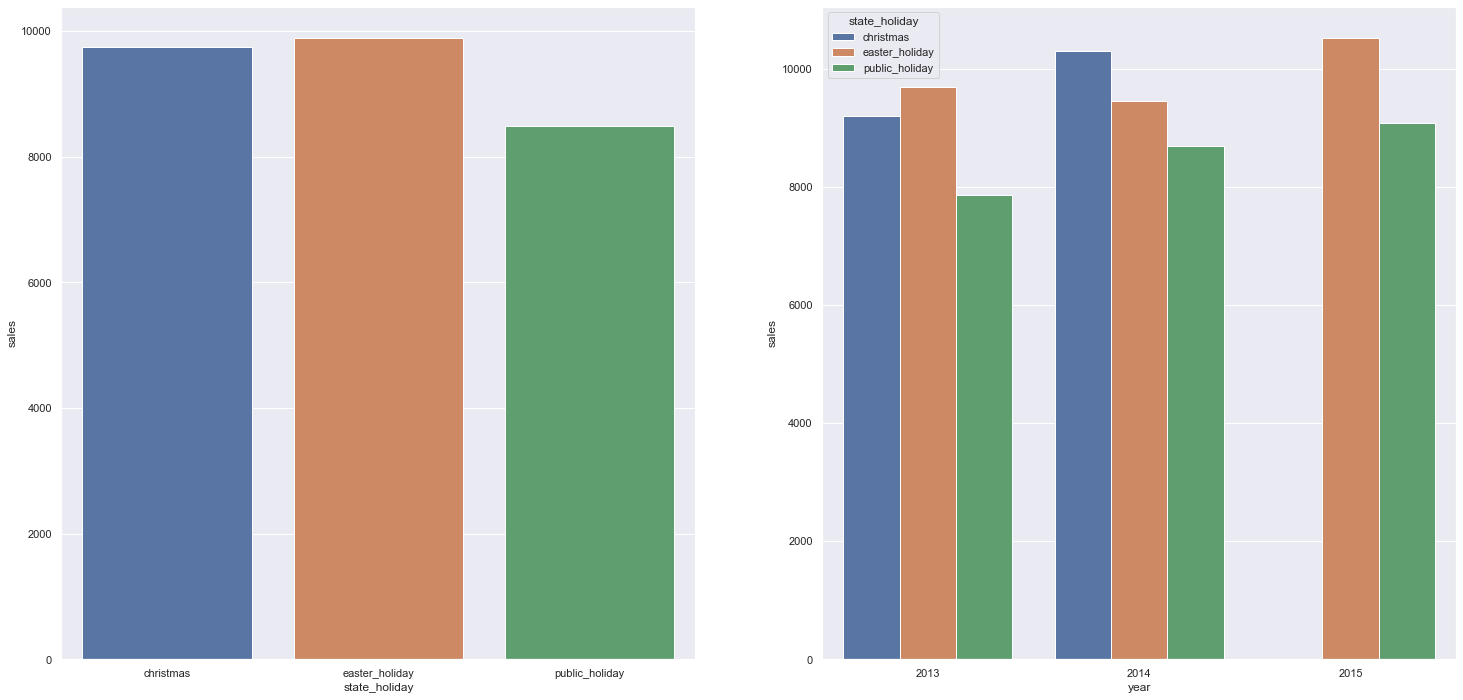

In [79]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).mean().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).mean().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

Now, regarding the Christmas mean selling value, it is not particularly different from other holidays. 

### **H8**. Stores should have higher sellings through years
**FALSE** Stores sell lower volume through years. But as there are only two years of information, it is worth to re assess this hypothesis when more information become available. 

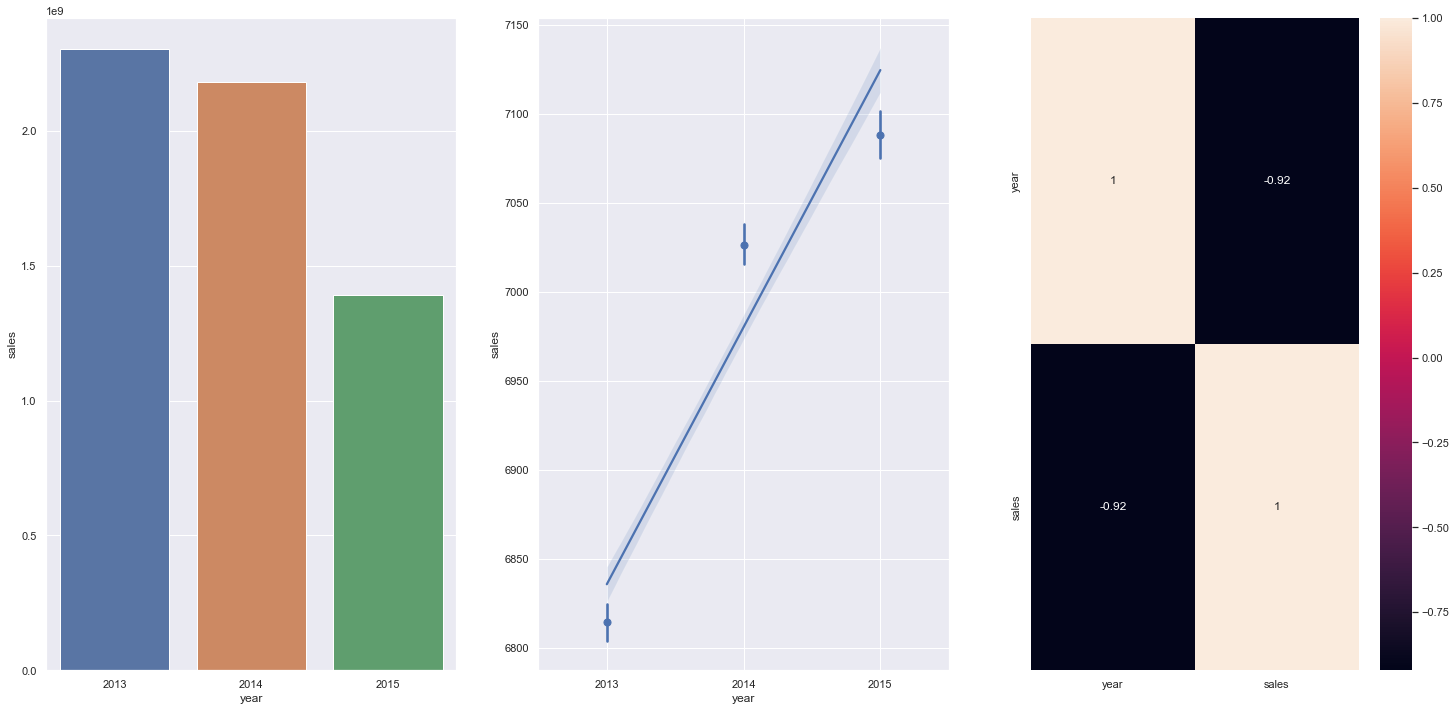

In [81]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot(x='year', y='sales', data=df4, x_estimator=np.mean)
plt.xlim(2012.5, 2015.5)
plt.xticks([2013,2014,2015])

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H9**. Stores should have higher selling volume on second semester each year
**FALSE**. Stores display higher selling volume on first semester


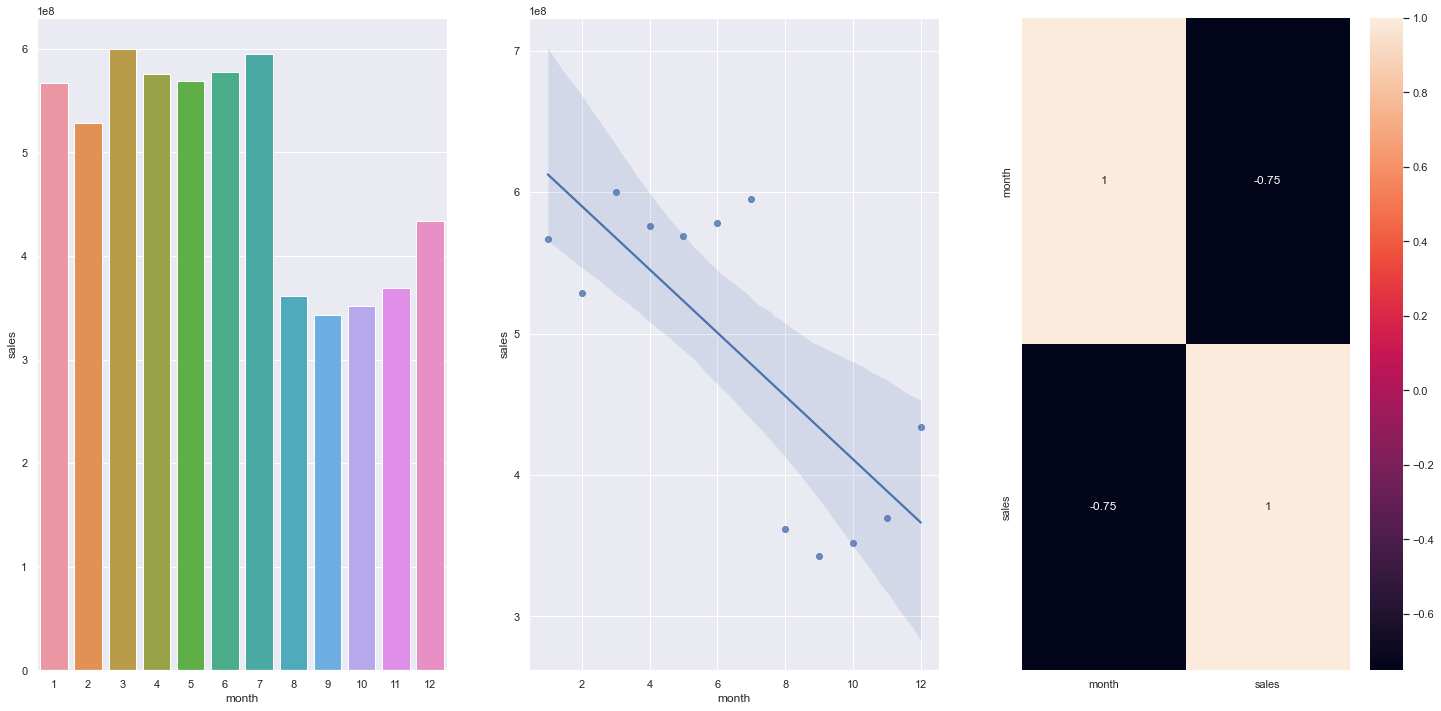

In [90]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

In [91]:
aux1

,month,sales
0,1,566728724
1,2,528734410
2,3,599831906
3,4,575895295
4,5,569248217
5,6,578112775
6,7,595059205
7,8,361791202
8,9,342570131
9,10,351878728


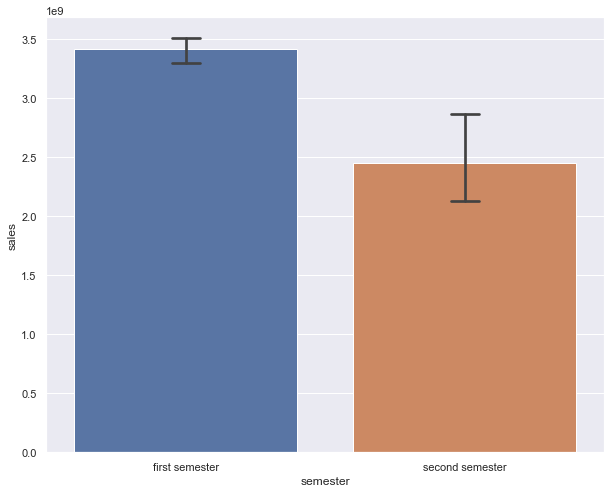

In [93]:
aux1['semester'] = aux1['month'].apply(lambda x: 'first semester' if x in [1,2,3,4,5,6] else 'second semester')
plt.figure(figsize=(10,8))
sns.barplot(x='semester', y='sales', data=aux1, estimator = sum, capsize=.1)
plt.show()

### **H10**. Stores should have higher selling volume after day 10 of month
**FALSE**. Stores display lesser selling volume after day 10

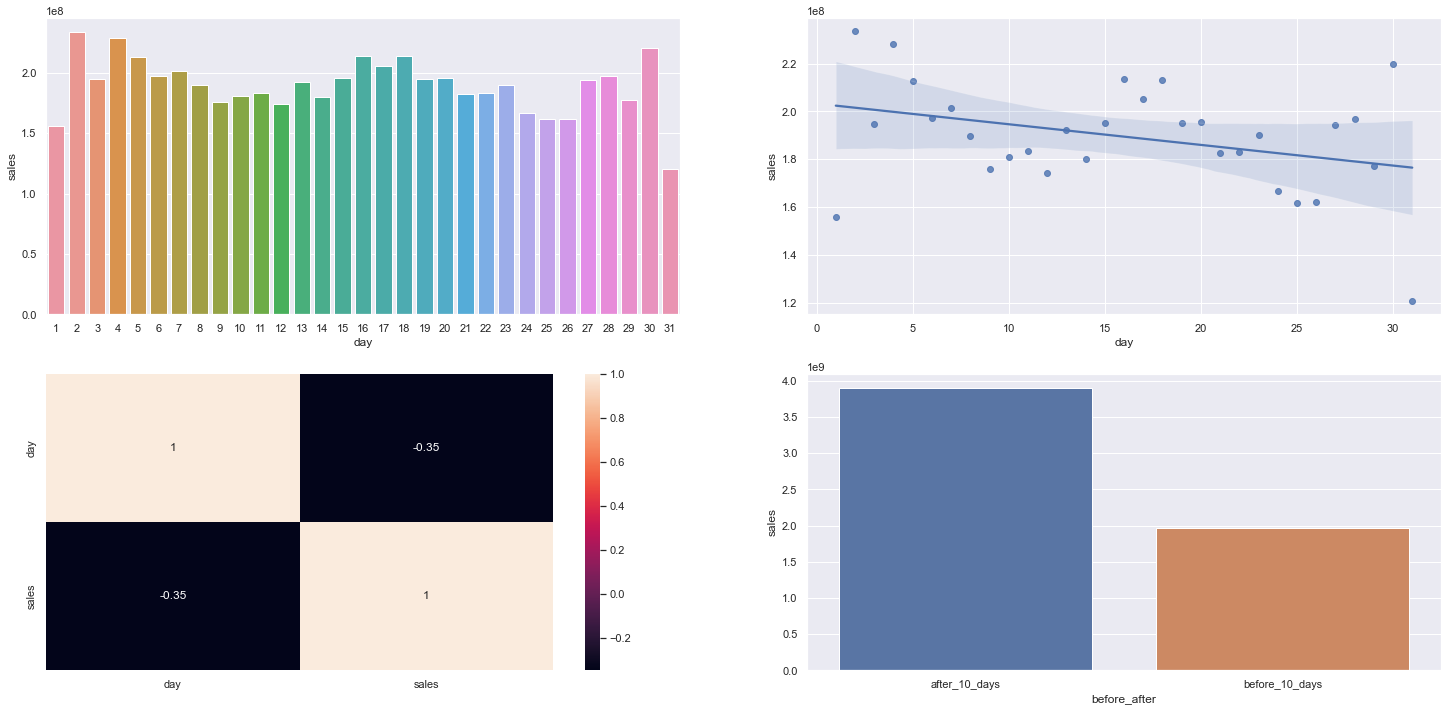

In [83]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

### **H11**. Stores should have lesser selling volume on weekends
**TRUE**. Stores display lesser selling volume on weekends

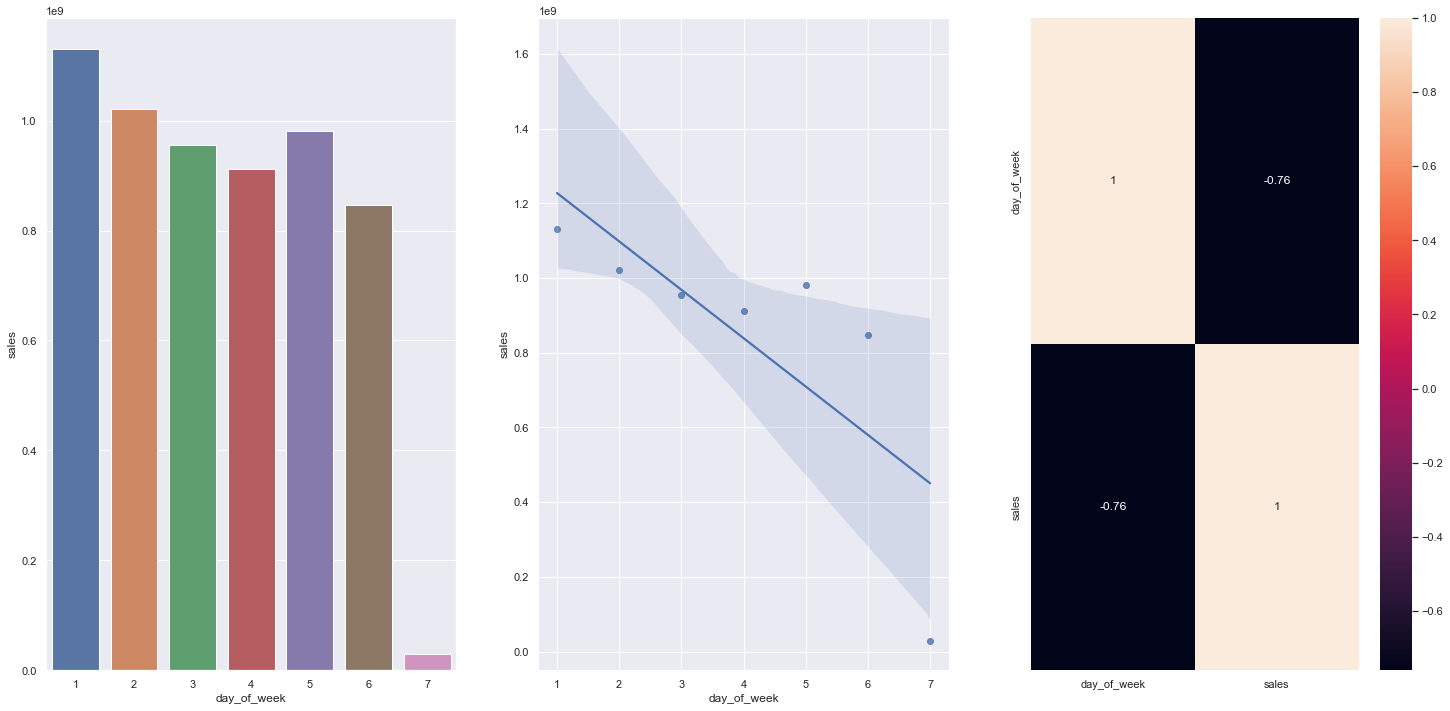

In [94]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H12**. Stores should have lesser selling volume on school holidays
**TRUE**. Stores display lesser selling volume on school holiday, except July and August. 

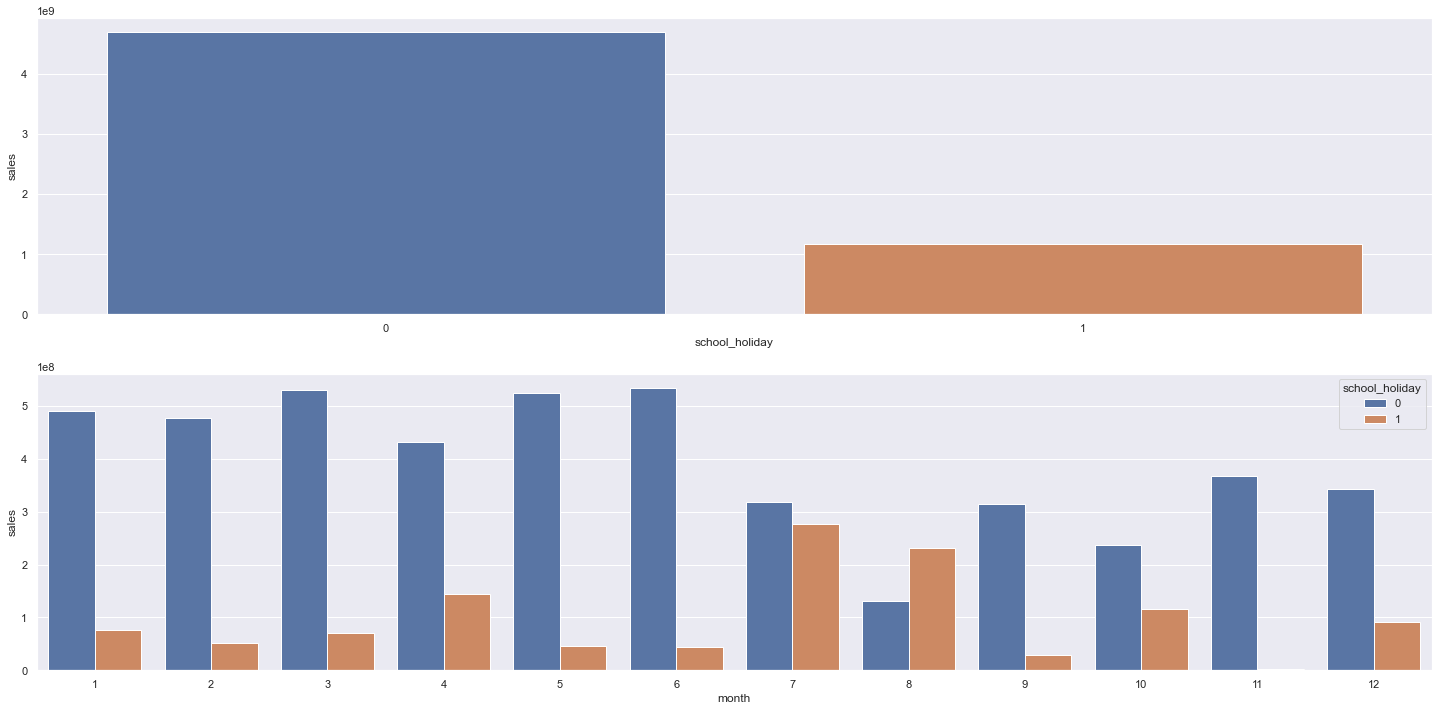

In [95]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### Hypothesis Summary

In [96]:
from tabulate import tabulate

In [98]:
tab =[['Hypothesis', 'Conclusion', 'Importance'],
      ['H1', 'False', 'Low'],  
      ['H2', 'False', 'Regular'],  
      ['H3', 'False', 'Regular'],
      ['H4', 'False', 'Low'],
      ['H5', '-', '-'],
      ['H7', 'False', 'Low'],
      ['H8', 'False', 'Regular'],
      ['H9', 'False', 'High'],
      ['H10', 'False', 'High'],
      ['H11', 'True', 'High'],
      ['H12', 'True', 'High'],
      ['H13', 'True', 'Low'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hypothesis    Conclusion    Importance
------------  ------------  ------------
H1            False         Low
H2            False         Regular
H3            False         Regular
H4            False         Low
H5            -             -
H7            False         Low
H8            False         Regular
H9            False         High
H10           False         High
H11           True          High
H12           True          High
H13           True          Low


## Multivariate Analysis

### Numerical Attributes

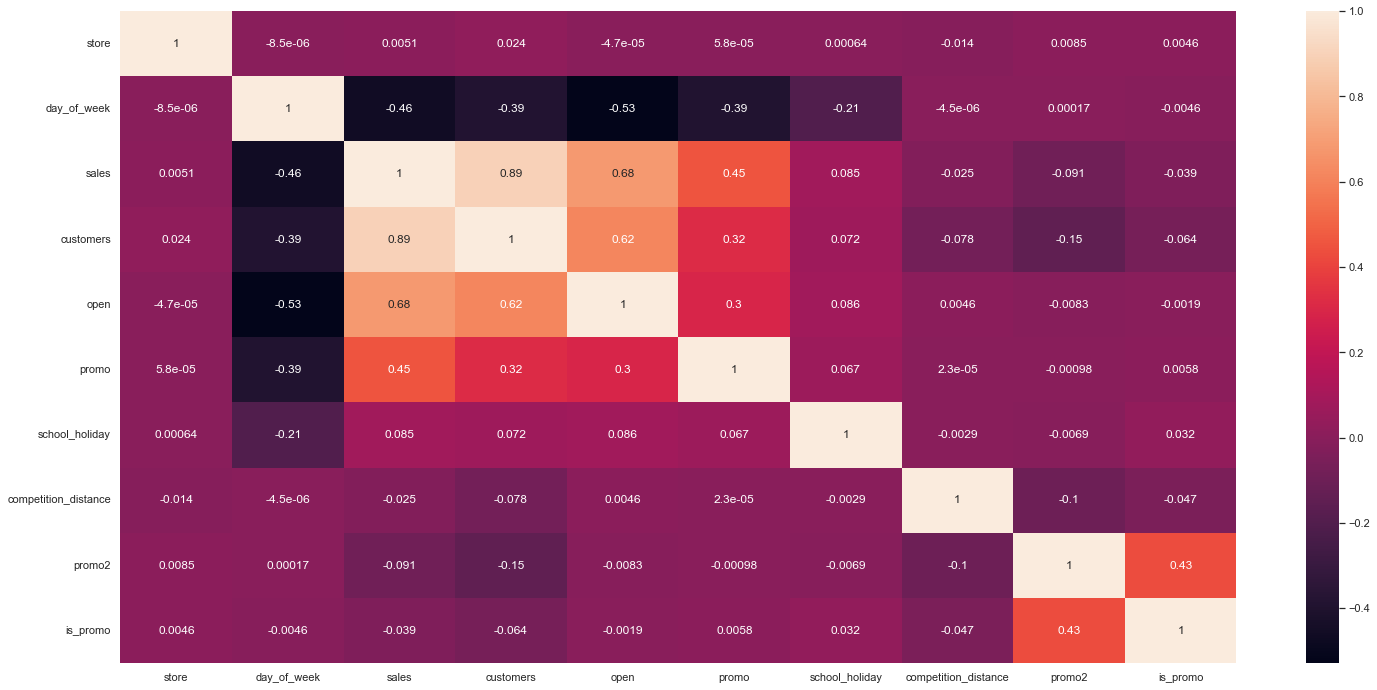

In [99]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### Categorical Attributes

<AxesSubplot:>

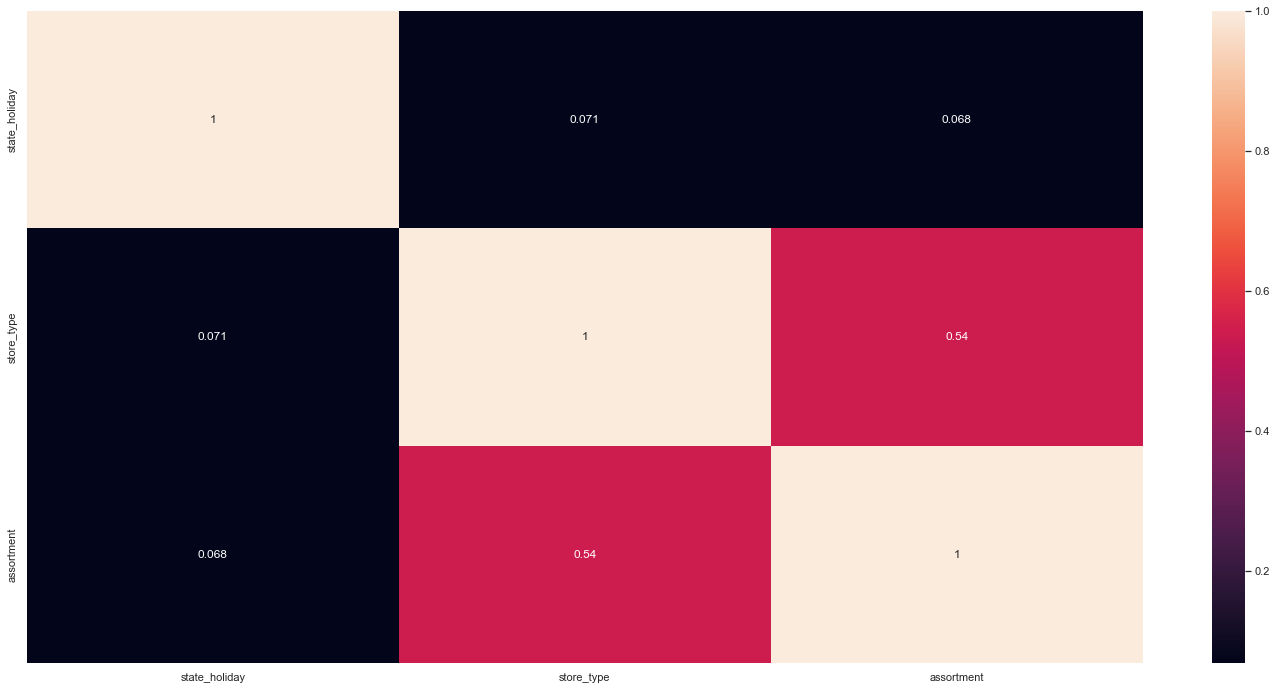

In [112]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

Note that the variables 'store_type' and 'assortment' have a reasonable correlation.

# Step 05 - Data Preparation <a class="anchor" id="step05"></a>

In this section, data modeling begins, which involves preparing the data and filtering the most relevant variables for the machine learning section

In [114]:
df5 = df4.copy()

## Normalization

After noting that there is no normal distribution involved, no normalization process is going to be carried out at this time. 

## Rescaling

The selection on how to scale variables is based on the presence of outliers. So, RobustScaler  is going to be used in competition_time_month while the other variables are going to be treated with MinMaxScaler

<AxesSubplot:xlabel='year'>

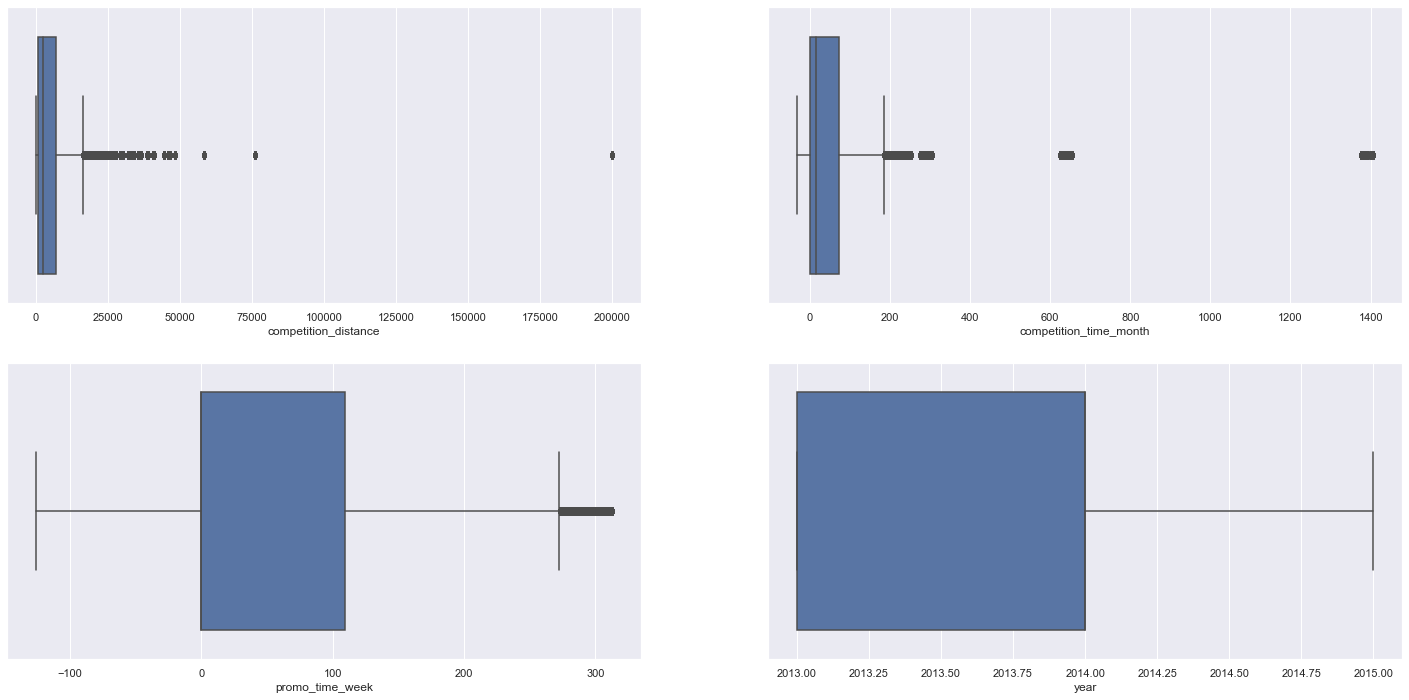

In [117]:
plt.subplot( 2, 2, 1 )
sns.boxplot(x = df5['competition_distance'])
plt.subplot( 2, 2, 2 )
sns.boxplot(x = df5['competition_time_month'])
plt.subplot( 2, 2, 3 )
sns.boxplot(x = df5['promo_time_week'])
plt.subplot( 2, 2, 4 )
sns.boxplot(x = df5['year'])

In [118]:

rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb') )

## Transformation

### Non-cyclical feature Encoding

In [120]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### Response Variable Transformation

In [121]:
df5['sales'] = np.log1p( df5['sales'] )

### Nature Transformation

As discussed [here](https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca), some variables with cyclical nature can be presented as a linear combination of sines and cosines. 

In [122]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

This way, for instance day would be presented as follows

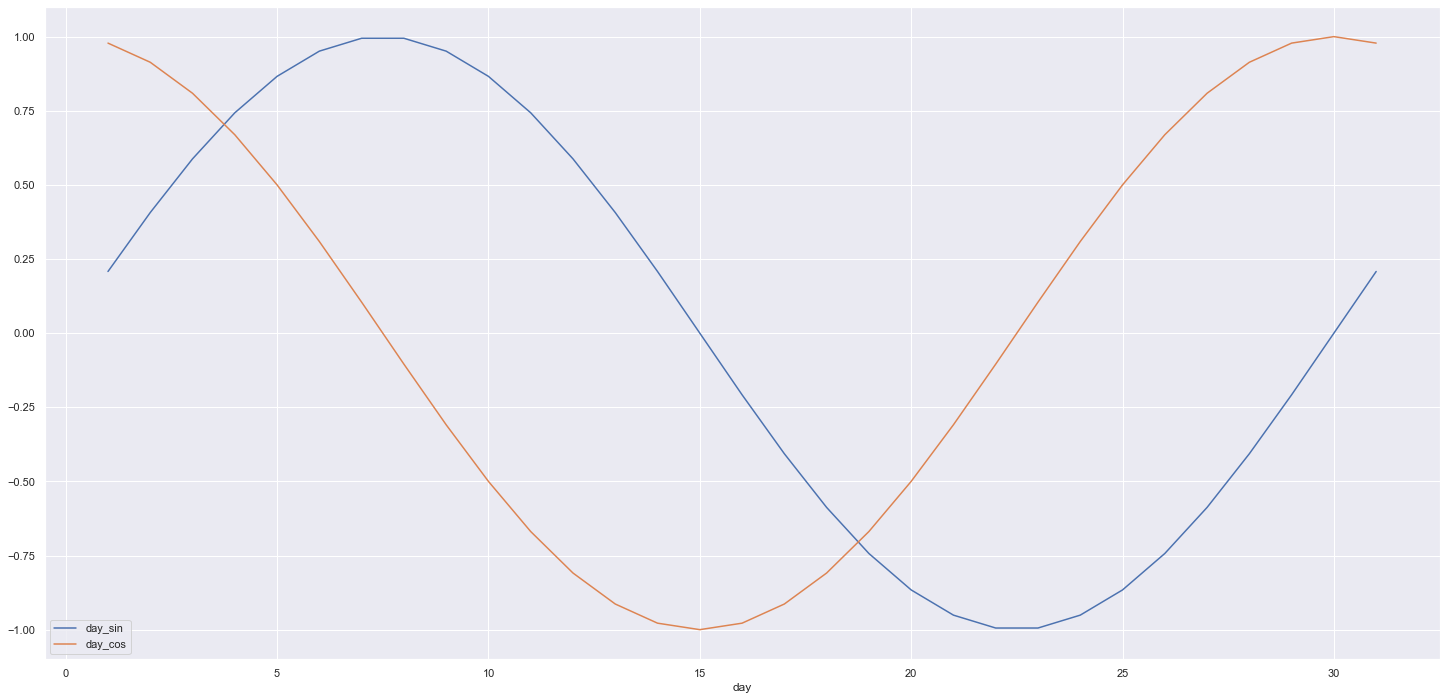

In [123]:
df5[['day','day_sin','day_cos']].groupby('day').mean().plot();

# Step 06 - Feature Selection <a class="anchor" id="step06"></a>

In [124]:
df6 = df5.copy()

In [125]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

## Splitting dataframe into training and test dataset

Sales records started on 01/02/2013 and ended for all stores in 07/31/2015. If our purpose is to provide forecast for the last six weeks, we need to compute the bracket date 

In [126]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0]- datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

Using such date (June 19, 2015) as reference to split the dataset in training and testing datasets 

In [127]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## Boruta as Feature Selector

Boruta is an effective feature selection algorithm providing recommendations to variables to consider. See more about Boruta [here](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a).

(afterrunning the script once, it is not necessary to run it again - the processing time is long and the result obtained should not vary significantly when changing the seed)

In [129]:
## training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )
#
## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### Best Features from Boruta

In [130]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## Manual Feature Selection

In [131]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# Step 07 - Machine Learning Modelling <a class="anchor" id="step07"></a>

As we approach the Machine Learning modeling, we sliced the train and test dataset to include only those variables given by the Boruta feature selection algorithm. 

In [132]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

As a way to measure how good a proposed model is, several classical goodness of fit measures are going to be used. To this end, let $r_j=y_j-\hat{y}_j$, where $\hat{y}_j$, is the predicted value using the model for $y_j$ where  $j = 1, 2, \cdots T$. We define 
1. $MAE=\frac{1}{n}\sum_{j=1}^T|r_j|$
2. $MAPE=\biggl(\frac{1}{n}\sum_{j=1}^T\frac{|r_j|}{y_j}\biggl)$
3. $RMSE=\sqrt{\frac{1}{n}\sum_{j=1}^T r_j^2}$

## Average Model

As a reference to compare, an average model is proposed. This is, a model where the forecast value for a store is the mean of all its selling. 

In [133]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## Linear Regression Model

Linear regression produces linear models minimizing the sum of squared errors (RMSE) between the actual and predicted values.

In [135]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### Linear Regression Model - Cross Validation

In [136]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


It should be noted that linear regression model does not perform better than the average. This suggests the idea that no linearity might be present within the structure of the data. 


##  Linear Regression Regularized Model - Lasso

Regularized linear regression balances the minimization of RMSE but adding a penalty term for the coefficients and tends to produce simpler models that are less prone to over fitting. See more about Lasso models [here](https://uc-r.github.io/regularized_regression)

In [137]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


###  Lasso - Cross Validation

In [138]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## Random Forest Regressor

In [139]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

MemoryError: could not allocate 58720256 bytes

###  Random Forest Regressor - Cross Validation

In [63]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.68 +/- 219.1,0.12 +/- 0.02,1256.08 +/- 320.36


## XGBoost Regressor

In [ ]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

### XGBoost Regressor - Cross Validation

In [65]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79


## Comparing Model's Performance

### Single Performance

In [66]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.622763,0.099960,1011.191561
0,XGBoost Regressor,843.112292,0.122609,1250.952634
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


As of this measures, it seems like the Random forest outperformed other models. But, as a way to reduce overfitting, a k-fold cross validation scheme is also used to assess models. 

### Real Performance - Cross Validation

In [67]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,837.68 +/- 219.1,0.12 +/- 0.02,1256.08 +/- 320.36
0,XGBoost Regressor,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79


Although Random forest performed better at this time, we will use the XGBoost model as our selected model. Thus, it will be fine-tuned. This decision is made based on resources as Random Forest would require much more memory went deployed in production than XGBoost. 

# Step 08 - Hyperparameter Fine Tuning <a class="anchor" id="step08"></a>

We now look forward to get a set of parameters that maximizes model learning and performance without overfitting.

Three hyperparameter adjustment strategies: 
1) Random search:
Advantages: fast, low cost and easy to implement
Disadvantages: may repeat already tested parameter sets and may not select the best parameter set for the model

2) Grid search:
Advantage: finding the best combination of parameters that maximize the model's performance (within the set of values available for each of the parameters)
Disadvantage: time consuming and very costly computationally

3) Bayesian search:
Advantages: it is able to find parameter values based on past learnings, in addition to being faster than grid search
Disadvantages: slower than random search

Will be implementing random search because it is faster, which is a preferred feature for this project.

## Random Search

In [140]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }
#
#MAX_EVAL = 5

In [69]:
#final_result = pd.DataFrame()
#
#for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
#    
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )
#
#    # performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#    final_result = pd.concat( [final_result, result] )
#        
#final_result

In [70]:
#final_result

## Final Model

Once run, the algorithm provides a recommended set of parameters to maximize model's learning. 

In [142]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [ ]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

[21:11:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [43]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.019542777303957218

# Step 09 - Translation and Interpreting Errors <a class="anchor" id="step09"></a>

Main difference between MAE/MAPE & RMSE is that MAE/MAPE are not sensitive to outliers, as the error is always absolute, divided by the number of samples. In RMSE, the error is squared, enhancing its impact; subsequently, it is divided by the sample number before extracting the square root.

**Useful to understand if the model is overestimating or underestimating predictions**

Model performance on the business:
comparison with the status quo: how the sales forecast is currently done vs. the model's forecast proposal revenue increase

In [141]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

NameError: name 'yhat_xgb_tuned' is not defined

## Business Performance

In [ ]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [ ]:
df92.sort_values( 'MAPE', ascending=False ).head()

In [ ]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

##  Total Performance

In [ ]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

## Machine Learning Performance

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

In [ ]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

This set of graphs summarizes the model's performance.

- The first (top left) shows sales and their respective forecasts, considering all stores.
- The second (top right) shows the error rate, where below 1 is valid for the periods where it underestimated and above 1 is valid for the periods it overestimated.
- The third (bottom left) is the error distribution, which resembles a normal distribution.
- The fourth (bottom right) shows the errors by the value of the predictions; it is noted that the errors for forecasts around \$8k tend to be greater, with the largest errors in the model (outliers) being in this range.
The last two graphs are used in residual analysis to help understand the model's weaknesses and what you need to do to increase its performance.

# Step 10 - Model Deployment <a class="anchor" id="step10"></a>

In [45]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open( 'model/model_rossmann.pkl', 'wb' ) )

## Rossman Class

In [17]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='/Users/Windows/Google drive/DS em produccao/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## API Handler

In [18]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( '/Users/meigarom/repos/DataScience_Em_Producao/model/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## API tester

In [54]:
import json

In [55]:
# loading test dataset
df10 = pd.read_csv( 'test.csv' )

In [92]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store']==20 ]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [93]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [97]:
# API Call
# url = 'http://127.0.0.1:5000/rossmann/predict' #test local 
url = 'https://rossmann-forecast-test.herokuapp.com/rossmann/predict' #Heroku deployed
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [98]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [99]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell ${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )

Store Number 20 will sell $274,315.86 in the next 6 weeks


In [ ]:
import requests
import json
import pandas as pd
from flask import Flask, request, Response


#constants
TOKEN = '5293016879:AAEZBzhu_MJXOxq1UHplKAd-Sxi2A7gHuIY'

# Info about the bot
#https://api.telegram.org/bot5293016879:AAEZBzhu_MJXOxq1UHplKAd-Sxi2A7gHuIY/getMe
# Get updates
#https://api.telegram.org/bot5293016879:AAEZBzhu_MJXOxq1UHplKAd-Sxi2A7gHuIY/getUpdates
## Webhook
#https://api.telegram.org/bot5293016879:AAEZBzhu_MJXOxq1UHplKAd-Sxi2A7gHuIY/setWebhook?url=https://ccd4ba71e54210.lhr.life
# Send Messages
#https://api.telegram.org/bot5293016879:AAEZBzhu_MJXOxq1UHplKAd-Sxi2A7gHuIY/sendMessage?chat_id=1133597071&text=Hi, Sebmatecho. Doing great, thanks!


def send_message(chat_id, text):
	url = 'https://api.telegram.org/bot{}/'.format(TOKEN)
	url = url + 'sendMessage?chat_id={}'.format(chat_id)
	r = requests.post(url, json={'text':text})
	print('Status Code {}'.format(r.status_code))

	return None

def load_dataset(store_id):
	# loading test dataset
	df10 = pd.read_csv( 'C:/Users/Windows/Google Drive/DS em produccao/test.csv' )
	df_store_raw = pd.read_csv('C:/Users/Windows/Google Drive/DS em produccao/store.csv')

	# merge test dataset + store
	df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

	# choose store for prediction
	df_test = df_test[df_test['Store']== store_id]

	if not df_test.empty:

		# remove closed days
		df_test = df_test[df_test['Open'] != 0]
		df_test = df_test[~df_test['Open'].isnull()]
		df_test = df_test.drop( 'Id', axis=1 )

		# convert Dataframe to json
		data = json.dumps( df_test.to_dict( orient='records' ) )
	else: 
		data ='error'

	return data

def predict(data):

	# API Call
	url = 'https://rossmann-forecast-test.herokuapp.com/rossmann/predict'
	header = {'Content-type': 'application/json' } 
	data = data

	r = requests.post( url, data=data, headers=header )
	print( 'Status Code {}'.format( r.status_code ) )

	d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

	return d1

def parse_message(message):
	chat_id = message['message']['chat']['id']
	store_id = message['message']['text']
	store_id = store_id.replace('/', '')

	try:
		store_id = int(store_id )
	except ValueError:
		store_id = 'error'
	return chat_id, store_id



#API initialize
app = Flask(__name__)

@app.route('/', methods = ['GET','POST'])
def index():
	if request.method == 'POST':
		message = request.get_json()

		chat_id, store_id = parse_message(message)
		if store_id!='error': 
		#loadind data
			data =load_dataset(store_id)

			if data!='error':
		#prediction
				d1 = predict(data)			
		#calculation
				d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()
		#send message
				msg =  'Store Number {} forecast for the next 6 weeks: ${:,.2f}'.format( 
				d2['store'].values[0], 
				d2['prediction'].values[0] ) 
				send_message(chat_id,msg)
				return Response('Ok', status = 200)
			else:	 
				send_message(chat_id, 'Store not available')
				return Response('Ok', status =200)

		else:
			send_message( chat_id, 'Store ID is wrong')
			return Response('Ok', status = 200)
		
	else:
		return '<h1> Rossmann Telegram BOT </h1>'

if __name__ == '__main__':
	app.run(host='0.0.0.0', port = 5000)